# Credit assignment through regression discontinuity design


## 1.1 The problem

In the following we consider a small network of spiking neurons $\mathbf{h} \in \mathbb{R}^n$ which is able to observe a cost function/reward signal, $C(x,y,W)$, for some computation that it is involved in. 

To adjust its weights to minimize this cost function a neuron must know the gradient:
$$
\beta_i \equiv \frac{\partial C}{\partial h_i}.
$$

This can be computed through backpropagation, $\beta_i^{BP} \equiv \beta_i$, however there are few known biologically plausible mechanisms for implementing backprop. Though some candidates have appeared recently. For instance the method of synthetic gradients uses reinforcement-learning style estimators for the gradient, $\hat{\beta}_i^{SG} \approx \beta_i^{BP}$, which addresses some of the issues with backprop.

Alternatively, in cases where the cost function is observed by the neuron, it could learn $\beta_i$ from this feedback. A na\"ive approximation of $\beta_i$ could proceed via a type of finite differences approach:
$$
\beta_i^{FD} \equiv \mathbb{E}(C|h_i = 1) - \mathbb{E}(C|h_i=0).
$$

An issue with the above estimator is that it is effectively only measuring the correlation between $h_i$ and $C$. Note that under the hypothetical scenario that backprop has a plausible implementation mechanism, backprop provides a _causal_ measure of $\beta_i$. That is, via backprop the neuron learns directly about its effect on $C$ through all of its downstream connections. If, at some point downstream of $h_i$, all of the weights through which $h_i$ may affect $C$ are zero then backprop will correctly report $\beta_i = 0$. The estimator based on $\beta_i^{FD}$ on the other hand can be biased by correlations with other neurons. For instance, we can imagine in the same no-effect scenario ($\beta_i = 0$) that $\beta_i^{FD}$ could be non-zero provided there was  another neuron $h_j$ whose activity was correlated with $h_i$ and for which there were non-zero downstream weights such that $\beta_j \ne 0$. 

The credit assignment problem in this correlated activity case is thus a challenge: how does a neuron learn _its_ specific effect on a cost function when its neighbors are correlated with its activity? Spike train correlations and their effect on coding have been well-studied (Shea-Brown studies...). (Things to do with spike time correlations and learning) (Mention node-perturbation methods)

## 1.2 The model

We will demonstrate our idea via a simple test system of $n=2$ leaky integrate and fire (LIF) neurons. The neurons thus obey
$$
\dot{v}_i = -g_L v_i + w_i\eta_i
$$
for $i = 1,2$. Integrate and fire means simply:
$$
v_i(t^+) = v_r, \quad \text{when }v_i(t) = \mu.
$$

Noisy input $\eta_i$ is comprised of a common DC current, $x$, and noise term, $\xi(t)$, plus an individual noise term, $\xi_i(t)$:
$$
\eta_i(t) = x + \sigma_i\left[\sqrt{1-c}\xi_i(t) + \sqrt{c}\xi(t)\right].
$$
The noise processes are independent white noise: $\mathbb{E}(\xi_i(t)\xi_j(t')) = \delta_{ij}\delta(t-t')$. This parameterization is chosen so that the inputs $\eta_{1,2}$ have correlation coefficient $c$. Output spike trains are defined as
$$
y_i(t) = \sum_s \delta(t-t_i^s)
$$
for $t_i^s$ the $s$th spike time.

In what follows simulations are performed with a step size of $\Delta t = 1ms$. Thus outputs at each time step become indicator functions:
$$
h_i^t = \mathbb{1}(\text{$i$ spikes in timebin $t$}).
$$

## 1.3 Some background

### Potential outcomes and causal effect

The Rubin causal model (RCM) provides a framework for reasoning about causal effects in terms of counterfactuals. In a simple setting, the model considers two _potential outcomes_: an outcome when a subject does receive a treatment, $Y(1)$, and an outcome when a subject does not receive a treatment, $Y(0)$ (i.e. a control subject). For a given subject, the _causal effect_ is the difference in potential outcomes:
$$\begin{equation}
 E_i = Y_i(1)-Y_i(0).
\end{equation}
$$

The _fundamental problem of causal inference_ is that, per subject, only one of these outcomes is ever observed. Either the subject receives the treatment, or does not -- one of $Y_i(0)$ or $Y_i(1)$ is a counterfactual, a what-if. In general causal effects must therefore be measured at a (sub)population level. This motivates considering the _average causal effect_:
$$
\begin{equation}
 \beta = \mathbb{E}(Y(1)-Y(0)).
\end{equation}
$$

If we let $W_i$ be a treatment random variable:

$$\begin{equation}
 W_i = \begin{cases}
        1, & \text{subject $i$ receives treatment};\\
        0, & \text{subject $i$ assigned control};
       \end{cases}
\end{equation}$$

then the observed outcome is
$$
\begin{equation}
 Y_i = W_iY_i(1) + (1-W_i)Y_i(0).
\end{equation}
$$

If $W_i$ is assigned to each subject at random (a randomized control trial) then $\beta$ can be computed directly from the treatment and control subpopulation means. In randomized cases, $W_i$ is independent from the potential outcomes. If $W_i$ were not independent from the potential outcomes then the measured causal effect (difference in means) could simply be a result of this correlation. (If a treatment is preferentially given to subjects with cancer, then we should of course expect to see a difference in cancer rates between treated and control groups.) A requirement for causal inference is therefore

$$\begin{equation}
 Y(1),Y(0) \perp W.
\end{equation}$$

In most cases of interest both the outcome and treatment variable are related to a set of observed covariates, $X$. Causal inference then requires:
$$\begin{equation}
 Y(1),Y(0) \perp W | X,
\end{equation}$$
which is called the _unconfoundedness assumption_.

Causal effect cannot be inferred among populations that either always receive treatment or do not. Thus, additionally, causal inference requires a non-zero probability of assignment to a treatment group for all subjects:

$$\begin{equation}
 0 < \mathbb{P}(W_i = 1|X_i = x) < 1 \quad \forall x.
\end{equation}$$
This is known as the _positivity_, or overlap, assumption.  Note that these are not the only assumptions typically made in this framework, just those relevant to describing regression discontinuity design. Often also invoked is: the 'stable unit treatment value assumption' (SUTVA) -- treatment of subjects are stable, do not interfere with one another and only take one form; and consistency -- the potential outcome $Y(W)$ matches the observed outcome $Y$ under $W$.

### Regression discontinuity design

Regression discontinuity (RD) design \cite{Imbens2008} is applicable in cases where treatment assignment is performed by thresholding on a covariate. In what follows let $X$ be this covariate and $Z$ be the remaining covariates. 
Thus, 
$$\begin{equation}
 W_i = \begin{cases}
        1, & X_i \ge \mu\\
        0, & X_i < \mu.
       \end{cases}
\end{equation}$$

The intuition behind RD design is that for subjects close to the threshold, $X_i \approx \mu$, whether or not treatment is received is essentially random, and the difference in observed outcome just below and above the threshold provides a measure of causal effect.

Thus we can estimate causal effect at $X=\mu$ via
$$\begin{align}
\beta_{RD} &= \mathbb{E}(Y(1)-Y(0)|X = \mu)\\
&= \lim_{x \to \mu^+}\mathbb{E}(Y|X = x) - \lim_{x\to \mu^-}\mathbb{E}(Y|X = x).
\end{align}$$

Note that the unconfoundedness assumption is satisfied trivially since, conditioned on $X$, $W$ is deterministic and therefore independent of potential outcomes. This deterministic assignment violates the positivity assumption, however. Thus RD design requires an additional continuity assumption:
$$\begin{equation}
\mathbb{E}(Y(0)|X = x) \text{ and } \mathbb{E}(Y(1)|X = x)
\end{equation}$$
are continuous in $x$. This ensures that an observed discontinuity in means is attributable to average causal effect, and not just discontinuous potential outcomes. 

Average causal effect can be estimated through nonparametric kernel regression, applied separately on either side of the threshold. Alternatively, a local linear regression can be performed on either side of the threshold, within a window of width $p$:
$$\begin{equation}
 Y = \begin{cases}
 \beta_l + \alpha_l (X-\mu)& \mu - p \le X < \mu \\
 \beta_r + \alpha_r (X-\mu)& \mu \le X \le \mu + p.
 \end{cases}
\end{equation}$$

The causal effect can then be inferred from the difference in estimated terms
$$\begin{equation}
\hat{\beta} = \hat{\beta_r} - \hat{\beta_l}.
\end{equation}$$

## 2 Estimation of $\beta_i$

## 2.1 Separating correlation and causation

We make the ideas from Section 1 about estimating $\beta_i$ a bit more formal. Let an input $x$ be fixed, but $\{h_i\}_{i=1}^n$ have a stochastic component such that $h_i$ and $C$ are both random variables. Let $\mathbf{h}$ be the random vector $(h_i)_{i=1}^n$. In a deterministic spiking network we could approximate $\beta_i$ via
$$
\beta_i \approx C(\mathbf{h}_{j\ne i}, h_i=1) - C(\mathbf{h}_{j\ne i}, h_i=0).
$$

The equivalent in a stochastic setting is a quantity that measures the change in $C$ given a change in $h_i$, with all other variables known. This is captured by the conditional expectation
$$
\beta_i = \mathbb{E}\left[\mathbb{E}\left[C|\mathbf{h}_{j\ne i},h_i = 1\right] - \mathbb{E}\left[C|\mathbf{h}_{j\ne i}, h_i=0\right]\right].
$$

The directed acyclic graph (DAG) that describes this setup is shown in Figure 1. Inspection of the DAG shows that the set of nodes $\{h_j\}_{j\ne i}$ satisfy the backdoor criteria with respect to $h_i \to C$, and are thus sufficient controls to provide an estimate of the causal effect of $h_i$ on $C$. This means we can interpret $\beta_i$ as a measure of average causal effect:
$$
\beta_i = \mathbb{E}\left[C|do(h_i=1)\right] - \mathbb{E}\left[C|do(h_i=0)\right].
$$

The problem with this estimator is that a neuron $h_i$ does not observe the other neurons' activity, which are the controls necessary to infer $\beta_i$.

A neuron could take 
$$
\beta_i^{FD} = \mathbb{E}(C|h_i=1) - \mathbb{E}(C|h_i=0)
$$
but this only provides an estimate of $\beta_i$ when $h_i \perp \mathbf{h}_{j\ne i}$. This follows because
$$
\begin{align}
\beta_i^{FD} &= \mathbb{E}(C|h_i=1) - \mathbb{E}(C|h_i=0)\\
             &= \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=1) | h_i=1) - \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=0) | h_i=0)\\
          \text{(by independence)}\quad   &= \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=1)) - \mathbb{E}(\mathbb{E}(C|\mathbf{h}_{j\ne i}, h_i=0))\\
          &= \beta_i.
\end{align}
$$
In general, $\beta_i^{FD}$ is biased. Therefore some other means is needed to estimate $\beta_i$ in a neuron that observes only its activity and $C$. 

We could imagine a neuron performing its own 'randomized control trial', in which it perturbs its output, independent of its inputs, and notes the effect on the cost function of its perturbations. This is known as node-perturbation (citations). While it does provide a measure of average causal effect, it requires the proposition that a neuron possesses a type of 'experimentation mode', randomized spiking independent from its inputs, that it uses to learn its cost gradient. It is unclear how a neuron may acheive this, nor if it is the most efficient way for it to learn $\beta_i$.

![DAG](dag.svg)
**Figure 1.** Input $x$ plus common noise $\xi$ drive spiking units $h_i$, which permits calculation of cost function $C$. Interpretting as a causal graph shows conditioning on $\mathbf{h}_{j\ne i}$ is sufficient to control for confounding and infer causal effect of $h_i$ on $C$.


## 2.2 Regression discontinuity design

Here we propose a modification of the FD estimator that draws on methods from causal inference, and that can recover an unbiased estimator of $\beta_i$, thus obviating the need for backprop or an 'experimentation mode'.

In essence, a neuron's activity is characterized by thresholded events -- spikes. We propose that this can be utilized by a neuron,  via RD design, to infer the effect of its activity on a cost function. To achieve this we propose that a neuron (compartment?) implicitly learns an estimate of the cost function of the form:
$$
C = \alpha_i v_i + \beta_i h_i + \gamma_i + \epsilon.
$$
where $v_i$ is membrane potential, $h_i$ acts as an indicator function for neuron $i$ spiking, constant term $\gamma_i$, and zero-mean error $\epsilon$. For simplicity we assume parameters $\alpha_i$ and $\gamma_i$ are the same below and above threshold. By estimating $\beta_i$ the neuron estimates its causal effect:
$$
\beta_i^{RD} \equiv \lim_{x \to \mu^+} \mathbb{E}(C|v_i = x) - \lim_{x \to \mu^-} \mathbb{E}(C|v_i=x).
$$

Thus, within a window $p$ of $v_i = \mu$:
$$\begin{align}
 \beta_i &\approx \mathbb{E}(C-\alpha v_i|{\mu \le v_i < \mu+p}) - \mathbb{E}(C-\alpha v_i|{\mu - p < v_i < \mu})\\
 &= \mathbb{E}(B_i|M_i(p)),
\end{align}$$
where we have let $B_i = [2h_i - 1][C-\alpha v_i]$ and $M_i(p)$ be the event that $v_i$ is within $p$ of $\mu$. Note that the constant term $\gamma_i$, not being a random variable, simply pulls outside of the expectation and cancels.

## 2.3 An RD learning rule 

Let $\mathbf{a}\in\mathbb{R}^q$ be activity from some reservior of $q$ LIF units, randomly connected and driven by input $x$ (i.e. a liquid state machine).

Each neuron will train a set of output weights from $\mathbf{a}$, $U \in\mathbb{R}^{(q+1)\times n}$, such that
$$
\beta^{RD} \approx U^T\mathbf{a},
$$
where we assume an added bias term appended to the output $\mathbf{a}$.

That is, for each unit $i$ we want the weighted output to minimize
$$
\begin{align}
\mathbf{u}_i^* &= \text{argmin}_{\mathbf{u}_i}\mathbb{E}\left(\left[\mathbf{u}_i^T \mathbf{a} - B_i\right]^2|M_i(p)\right).
\end{align}
$$

For a fixed input $x$ the activity $\mathbf{a}$ is independent from $\mathbf{h}$ and $\mathbf{v}$, meaning the solution to the above linear regression problem is simply
$$
\begin{align}
\mathbb{E}(B_i|M_i(p)) = \beta_i^{RD}.
\end{align}
$$

If we let our estimate come from $T$ time bins, giving an activity matrix $A\in\mathbb{R}^{q\times T}$, then our estimator is
$$
\begin{align}
\hat{\mathbf{u}}_i = \text{argmin}_{\mathbf{u}_i}\sum_{t:(\mu - p < v_{i,t} < \mu + p)}^T\left[\mathbf{u}_i^T \mathbf{a}_t - B_{i,t}\right]^2.
\end{align}
$$

This is a linear regression performed over time points in which unit $i$'s voltage is within $p$ of threshold. In an online setting we can solve this with stochastic gradient descent. Our weight updates are:
$$
\Delta \hat{\mathbf{u}}_i = -\eta \left[\mathbf{u}_i^T \mathbf{a}_t - B_{i,t}\right]\mathbf{a}_t
$$
for learning rate $\eta$, and for all time points at which $v_{i,t}$ is within $p$ of threshold $\mu$. 

We can also write this out as:
$$
\Delta \hat{\mathbf{u}}_i = \begin{cases}
-\eta \left[\mathbf{u}_i^T \mathbf{a}_t - (C-\alpha v_{i}) \right]\mathbf{a}_t,&\text{$h_i$ spikes}\\
-\eta \left[\mathbf{u}_i^T \mathbf{a}_t + (C-\alpha v_{i}) \right]\mathbf{a}_t,&\text{$h_i$ does not spike}.
\end{cases}
$$

Of course, the benefit comes from training the output weights on a range of inputs $x$, not just one input, such that the network learns $\beta_i^{RD}(x)$. (This needs more detail)

### Learning $\alpha$ and $\gamma$

We assumed $\alpha_i$ was known in the above. On the basis of simulations below, we will for the moment assume the gradient $\alpha_i$ is zero.

## 3 Simulations

To begin, define a simple cost function per time bin
$$
C_t(\mathbf{h}_t; x, \mathbf{w}) = (v_1 h_1^t + v_2h_2^t - x^2)^2.
$$

We simulate this system below, and show how the various estimators of $\beta_i$ relate to each other for different values of $c$.

Before doing anything systemically we examine the system's output and its relation to cost function.

## 3.1 Basic properties

In [309]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from pandas.plotting import autocorrelation_plot as autocorr
import pandas as pd

from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM
from lib.causal import causaleffect, causaleffect_linear

dt = 0.001         #Step size
t = 10             #Simulation time
tr = 0.003         #Refractory period
mu = 1             #Threshold
reset = 0          #Reset potential
xsigma = 1         #Std dev of input x
n = 2              #Number of neurons
tau = 1            #Time constant
c = .99            #Correlation between noise inputs
sigma = 20         #Std dev of noise process

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Initialize voltage and spike train variables
T = np.ceil(t/dt).astype(int)
Tr = np.ceil(tr/dt).astype(int)
times = np.linspace(0,t,T)

v = np.zeros((n,T))
h = np.zeros((n,T))
vt = np.zeros(n)
r = np.zeros(n)

#Choose a random input x, input, output weights, and noise processes
#x = abs(rand.randn()*xsigma)+10
#W = 5*rand.randn(n)
#V = 5*rand.randn(n)

#Or just make these deterministic
x = 3
W = np.array([5, 5])
V = np.array([8, -4])

xi = sigma*rand.randn(n+1,T)/np.sqrt(tau)
xi[0,:] = xi[0,:]*np.sqrt(c)
xi[1:,:] = xi[1:,:]*np.sqrt(1-c)

In [6]:
#Simulate T seconds
for i in range(T):
    dv = -vt/tau + np.multiply(W,(x + xi[0,i] + xi[1:,i]))
    vt = vt + dt*dv
    #Find neurons that spike
    s = vt>mu
    #Save the voltages and spikes
    h[:,i] = s.astype(int)
    v[:,i] = vt
    #Make spiking neurons refractory
    r[s] = Tr
    #Set the refractory neurons to v_reset
    vt[r>0] = reset
    vt[vt<reset] = reset
    #Decrement the refractory counters
    r[r>0] -= 1
        
#Cost function per time point
C = (V[0]*h[0,:]+V[1]*h[1,:]-x**2)**2

#True causal effect for each unit
beta1 = V[0]**2 + 2*V[0]*V[1]*np.mean(h[1,:])-2*V[0]*x**2
beta2 = V[1]**2 + 2*V[0]*V[1]*np.mean(h[0,:])-2*V[1]*x**2

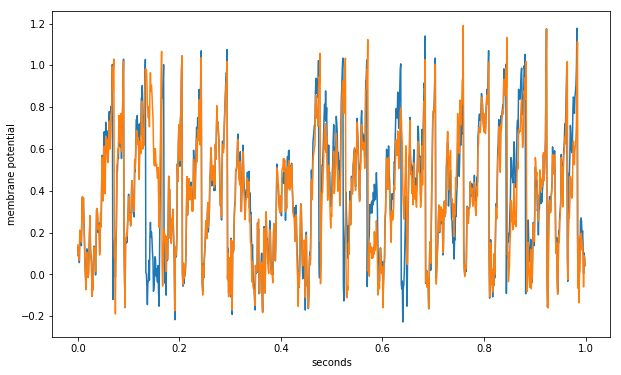

In [8]:
#Plot traces
t_idx = range(1000)
plt.plot(times[t_idx],v[0,t_idx], times[t_idx],v[1,t_idx])
plt.xlabel('seconds')
plt.ylabel('membrane potential');

In [9]:
#Plot cost as a function of membrane potential
clf = KernelRidge(kernel = 'rbf', gamma=3)
lr = linear_model.LinearRegression()

x0ltMu = v[0,v[0,:]<mu]
lr.fit(x0ltMu.reshape(-1,1), C[v[0,:]<mu].reshape(-1,1)) 
x0ltMu.sort()
y0ltMu = lr.predict(x0ltMu.reshape(-1,1))

x1ltMu = v[1,v[1,:]<mu]
lr.fit(x1ltMu.reshape(-1,1), C[v[1,:]<mu].reshape(-1,1)) 
x1ltMu.sort()
y1ltMu = lr.predict(x1ltMu.reshape(-1,1))

x0gtMu = v[0,v[0,:]>mu]
lr.fit(x0gtMu.reshape(-1,1), C[v[0,:]>mu].reshape(-1,1)) 
x0gtMu.sort()
y0gtMu = lr.predict(x0gtMu.reshape(-1,1))

x1gtMu = v[1,v[1,:]>mu]
lr.fit(x1gtMu.reshape(-1,1), C[v[1,:]>mu].reshape(-1,1)) 
x1gtMu.sort()
y1gtMu = lr.predict(x1gtMu.reshape(-1,1))

#Estimate the means
C1ltMu = np.mean(C[v[0,:]<mu])
C1gtMu = np.mean(C[v[0,:]>mu])
C2ltMu = np.mean(C[v[1,:]<mu])
C2gtMu = np.mean(C[v[1,:]>mu])

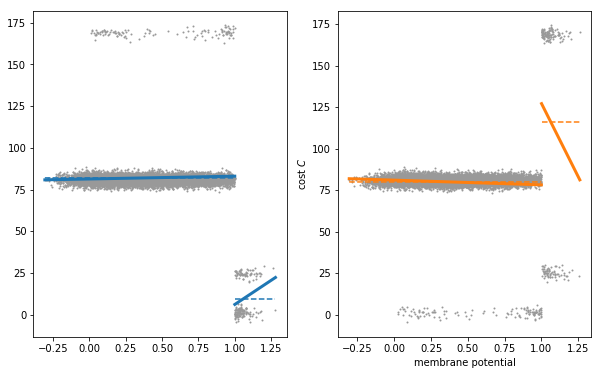

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2, sharey = False)
ms = 2
ax1.plot(v[0,:], C+2*rand.randn(C.shape[0]), '.', markersize = ms, color=(.6,.6,.6))
plt.ylabel('cost $C$')
plt.xlabel('membrane potential')
ax2.plot(v[1,:], C+2*rand.randn(C.shape[0]), '.', markersize = ms, color=(.6,.6,.6))
plt.xlabel('membrane potential')

ax1.plot(x0ltMu,y0ltMu,'C0',x0gtMu,y0gtMu,'C0', linewidth=3);
ax2.plot(x1ltMu,y1ltMu,'C1',x1gtMu,y1gtMu,'C1', linewidth=3);

ax1.plot(x0ltMu, C1ltMu*np.ones(x0ltMu.shape), '--C0')
ax1.plot(x0gtMu, C1gtMu*np.ones(x0gtMu.shape), '--C0')
ax2.plot(x1ltMu, C2ltMu*np.ones(x1ltMu.shape), '--C1')
ax2.plot(x1gtMu, C2gtMu*np.ones(x1gtMu.shape), '--C1')

The above shows the cost as a function of membrane potential, for unit 1 (left) and unit 2 (right). The change in the mean value of the cost at the discontinuity is an estimate of causal effect. Lines represent linear models fit to either side of threshold. Dashed lines represent mean cost on either side of threshold. The overall mean on either side of the discontinuity is biased by the correlation of unit 1 and unit 2. 

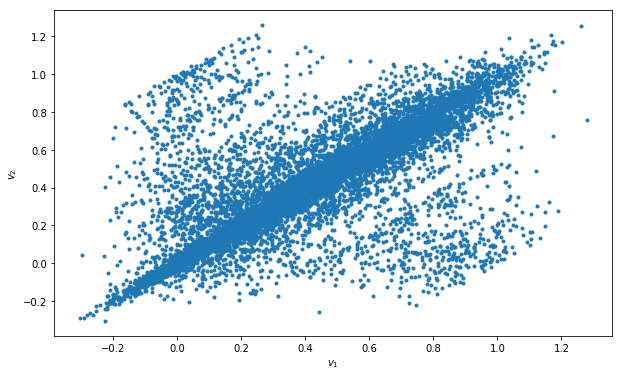

In [11]:
#Relation between v1 and v2
fig, ax1 = plt.subplots(1,1)
ax1.plot(v[0,:], v[1,:], '.');
plt.xlabel('$v_1$')
plt.ylabel('$v_2$');

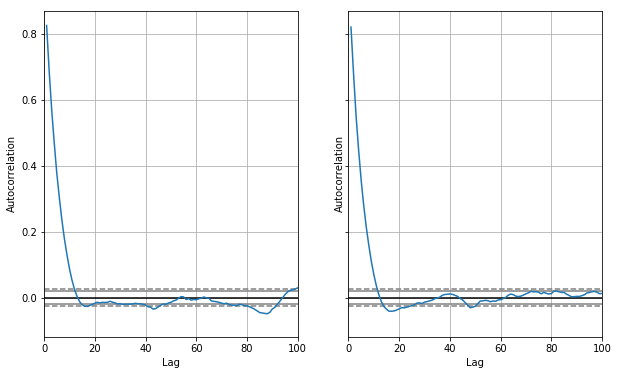

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
v1 = pd.Series(v[0,:])
v2 = pd.Series(v[1,:])
autocorr(v1, ax=ax1)
ax1.set_xlim([0, 100])
autocorr(v2, ax=ax2)
ax2.set_xlim([0, 100]);

In [13]:
#Simulate the 'counterfactuals' -- show the cost function assuming neuron i either always does or does not fire
C_unit1is1 = (V[0]+V[1]*h[1,:]-x**2)**2
C_unit1is0 = (V[1]*h[1,:]-x**2)**2
C_unit2is1 = (V[0]*h[0,:] + V[1]-x**2)**2
C_unit2is0 = (V[0]*h[0,:] - x**2)**2

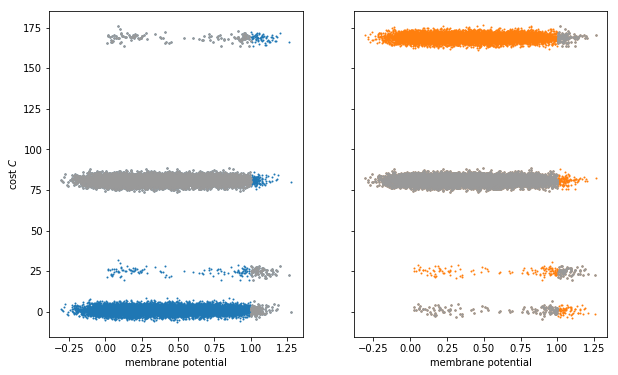

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2, sharey = True)
ms = 2
noise = 2*rand.randn(C.shape[0])
ax1.plot(v[0,:], C_unit1is1+noise, '.C0', markersize = ms)
ax1.plot(v[0,:], C_unit1is0+noise, '.C0', markersize = ms)
ax1.plot(v[0,:], C+noise, '.', markersize = 3, color = (0.6, 0.6, 0.6))
ax1.set_ylabel('cost $C$')
ax1.set_xlabel('membrane potential')
ax2.plot(v[1,:], C_unit2is1+noise, '.C1', markersize = ms)
ax2.plot(v[1,:], C_unit2is0+noise, '.C1', markersize = ms)
ax2.plot(v[1,:], C+noise, '.', markersize = 3, color = (0.6, 0.6, 0.6))
ax2.set_xlabel('membrane potential')

Plot of 'counter factuals'. Gray points show cost function per observed outcomes for unit 1 (left) and unit 2 (right), colored points show cost function for unobserved outcomes. 

## 3.2 Estimate $\beta_i^{RD}$ for different window sizes, compare to actual $\beta_i$


In [2]:
nS = 40
sizes = np.linspace(0.02, 1, nS);
mce = np.zeros((n, nS))
se_mce = np.zeros((n, nS))
for i,p in enumerate(sizes):
    for j in range(n):
        abv = (v[j,:]>mu) & (v[j,:]<(mu+p))
        blo = (v[j,:]<mu) & (v[j,:]>(mu-p))
        C_abv = C[abv]
        C_blo = C[blo]
        mce[j,i] = np.mean(C_abv)-np.mean(C_blo)
        se_mce[j,i] = np.sqrt(np.std(C_abv)**2+np.std(C_blo)**2)/np.sqrt(len(C_abv)+len(C_blo))

NameError: name 'v' is not defined

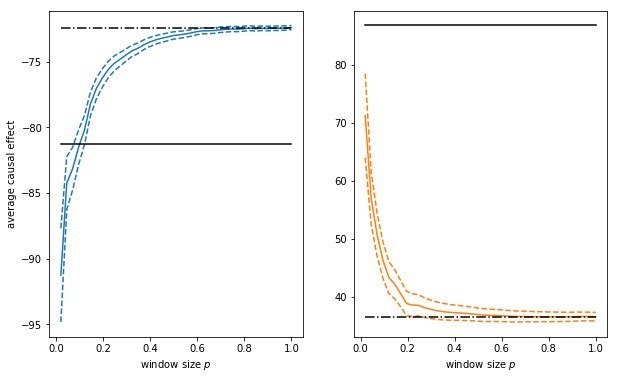

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(sizes, mce[0,:],'C0')
ax1.plot(sizes, mce[0,:]+se_mce[0,:],'--C0')
ax1.plot(sizes, mce[0,:]-se_mce[0,:],'--C0')
ax1.plot(sizes, beta1*ones(sizes.shape), color=(0,0,0))
ax1.plot(sizes, mce[0,-1]*ones(sizes.shape), '-.', color=(0,0,0))
ax2.plot(sizes, mce[1,:], 'C1')
ax2.plot(sizes, mce[1,:]+se_mce[1,:], '--C1')
ax2.plot(sizes, mce[1,:]-se_mce[1,:], '--C1')
ax2.plot(sizes, beta2*ones(sizes.shape), color=(0,0,0))
ax2.plot(sizes, mce[1,-1]*ones(sizes.shape), '-.', color=(0,0,0))

ax1.set_xlabel('window size $p$')
ax1.set_ylabel('average causal effect')
ax2.set_xlabel('window size $p$');

Here the estimated $\beta_i^{RD}$ is shown as a function of $p$, the window size over which it is computed. The solid curves shows the true $\beta_i$ and the dash-dotted curve shows the 'finite different' estimation $\beta_i^{FD}$. Left plot is unit 1, right is unit 2. The colored dashed lines show the SEM plus/minus the estimate. Can get a better estimate of SEM through more simulations/resampling. 

Still, plot shows that RD design does help obtain a better estimate of $\beta$.

## 3.3 Comparing $\beta_i^{FD}$, $\beta_i^{RD}$ and $\beta_i^{BP}$ for different $c$, different $p$ values

In [33]:
#To do things more systematically we rely on lib.lif.LIF class to do simulations
#Load default params as defined above
params = ParamsLIF()
params_orig = ParamsLIF()
lif = LIF(params)

nsims = 500
cvals = 1-np.logspace(-2,0,7)
pvals = np.linspace(0.01, 1, 10)
#wvals = 

#c (correlation between noise inputs)
beta_rd_c = np.zeros((len(cvals), nsims, params.n))
beta_fd_c = np.zeros((len(cvals), nsims, params.n))
beta_bp_c = np.zeros((len(cvals), nsims, params.n))

#For each sim we come up with mean causal effect estimate for p = 0.05 (RD), and p = 1 (FD)
#Compute a 'bias-variance' tradeoff curve as a function of c, p, W

p = 0.03
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in range(nsims):
        (v, h, Cost, betas) = lif.simulate()
        beta_rd_c[i,j,:] = causaleffect(v, Cost, p, params)
        beta_fd_c[i,j,:] = causaleffect(v, Cost, 1, params)
        beta_bp_c[i,j,:] = betas
        
m_beta_rd_c = np.mean(beta_rd_c, 1)
se_beta_rd_c = np.std(beta_rd_c, 1)

m_beta_fd_c = np.mean(beta_fd_c, 1)
se_beta_fd_c = np.std(beta_fd_c, 1)

m_beta_bp_c = np.mean(beta_bp_c, 1)
se_beta_bp_c = np.std(beta_bp_c, 1)

Running 500 simulations with c=0.99
Running 500 simulations with c=0.9784556531
Running 500 simulations with c=0.953584111664
Running 500 simulations with c=0.9
Running 500 simulations with c=0.784556530997
Running 500 simulations with c=0.535841116639
Running 500 simulations with c=0.0


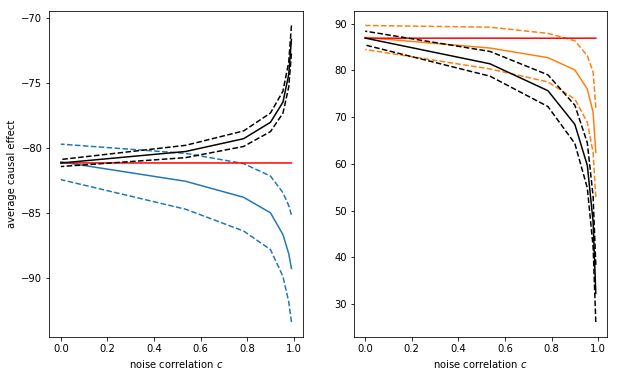

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2)

#RD
ax1.plot(cvals, m_beta_rd_c[:,0],'C0')
ax1.plot(cvals, m_beta_rd_c[:,0]+se_beta_rd_c[:,0],'--C0')
ax1.plot(cvals, m_beta_rd_c[:,0]-se_beta_rd_c[:,0],'--C0')

#FD and BP
ax1.plot(cvals, m_beta_bp_c[:,0], color=(1,0,0))
ax1.plot(cvals, m_beta_fd_c[:,0]+se_beta_fd_c[:,0], '--', color=(0,0,0))
ax1.plot(cvals, m_beta_fd_c[:,0]-se_beta_fd_c[:,0], '--', color=(0,0,0))
ax1.plot(cvals, m_beta_fd_c[:,0], color=(0,0,0))

#RD
ax2.plot(cvals, m_beta_rd_c[:,1],'C1')
ax2.plot(cvals, m_beta_rd_c[:,1]+se_beta_rd_c[:,1],'--C1')
ax2.plot(cvals, m_beta_rd_c[:,1]-se_beta_rd_c[:,1],'--C1')

#FD and BP
ax2.plot(cvals, m_beta_bp_c[:,1], color=(1,0,0))
ax2.plot(cvals, m_beta_fd_c[:,1]+se_beta_fd_c[:,1], '--', color=(0,0,0))
ax2.plot(cvals, m_beta_fd_c[:,1]-se_beta_fd_c[:,1], '--', color=(0,0,0))
ax2.plot(cvals, m_beta_fd_c[:,1], color=(0,0,0))

ax1.set_xlabel('noise correlation $c$')
ax1.set_ylabel('average causal effect')
ax2.set_xlabel('noise correlation $c$');

Here the solid red curves are $\beta_i^{BP}$. The blue/orange curve shows the $\beta_i^{RD}$ estimator for unit 1 and 2, respectively, as a function of the input noise correlation $c$. The dashed curves are the estimates plus/minus the SE. The solid black curve represents the $\beta_i^{FD}$ estimates. The RD estimates are more variable, but less biased than the FD estimates. Increasing correlation $c$ between unit 1 and unit 2 makes both FD and RD more biased. Note also that for independent processes both methods estimate $\beta_i^{BP}$ accurately.

In [26]:
# p (window size)
pvals = np.linspace(0.01, 1, 10)

beta_rd_p = np.zeros((len(pvals), nsims, params.n))
beta_fd_p = np.zeros((len(pvals), nsims, params.n))
beta_bp_p = np.zeros((len(pvals), nsims, params.n))

lif.setup(params_orig)

(v, h, Cost, betas) = lif.simulate()
for i,p in enumerate(pvals):
    for j in range(nsims):
        beta_rd_p[i,j,:] = causaleffect(v, Cost, p, params)
        beta_fd_p[i,j,:] = causaleffect(v, Cost, 1, params)
        beta_bp_p[i,j,:] = betas
        
m_beta_rd_p = np.mean(beta_rd_p, 1)
se_beta_rd_p = np.std(beta_rd_p, 1)

m_beta_fd_p = np.mean(beta_fd_p, 1)
se_beta_fd_p = np.std(beta_fd_p, 1)

m_beta_bp_p = np.mean(beta_bp_p, 1)
se_beta_bp_p = np.std(beta_bp_p, 1)

Running 500 simulations with p=0.01
Running 500 simulations with p=0.12
Running 500 simulations with p=0.23
Running 500 simulations with p=0.34
Running 500 simulations with p=0.45
Running 500 simulations with p=0.56
Running 500 simulations with p=0.67
Running 500 simulations with p=0.78
Running 500 simulations with p=0.89
Running 500 simulations with p=1.0


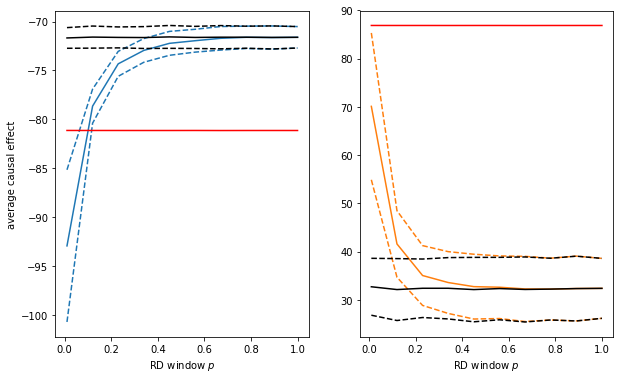

In [32]:
#Make some plots
fig, (ax1, ax2) = plt.subplots(1,2)

#RD
ax1.plot(pvals, m_beta_rd_p[:,0],'C0')
ax1.plot(pvals, m_beta_rd_p[:,0]+se_beta_rd_p[:,0],'--C0')
ax1.plot(pvals, m_beta_rd_p[:,0]-se_beta_rd_p[:,0],'--C0')

#FD and BP
ax1.plot(pvals, m_beta_bp_p[:,0], color=(1,0,0))
ax1.plot(pvals, m_beta_fd_p[:,0]+se_beta_fd_p[:,0], '--', color=(0,0,0))
ax1.plot(pvals, m_beta_fd_p[:,0]-se_beta_fd_p[:,0], '--', color=(0,0,0))
ax1.plot(pvals, m_beta_fd_p[:,0], color=(0,0,0))

#RD
ax2.plot(pvals, m_beta_rd_p[:,1],'C1')
ax2.plot(pvals, m_beta_rd_p[:,1]+se_beta_rd_p[:,1],'--C1')
ax2.plot(pvals, m_beta_rd_p[:,1]-se_beta_rd_p[:,1],'--C1')

#FD and BP
ax2.plot(pvals, m_beta_bp_p[:,1], color=(1,0,0))
ax2.plot(pvals, m_beta_fd_p[:,1]+se_beta_fd_p[:,1], '--', color=(0,0,0))
ax2.plot(pvals, m_beta_fd_p[:,1]-se_beta_fd_p[:,1], '--', color=(0,0,0))
ax2.plot(pvals, m_beta_fd_p[:,1], color=(0,0,0))

ax1.set_xlabel('RD window $p$')
ax1.set_ylabel('average causal effect')
ax2.set_xlabel('RD window $p$');

Here the solid red curves are $\beta_i^{BP}$. The blue/orange curve shows the $\beta_i^{RD}$ estimator for unit 1 and 2, respectively, as a function of RD window size $p$. The dashed curves are the estimates plus/minus the SE. The solid black curve represents the $\beta_i^{FD}$ estimates. As $p\to 1$ the RD method converges to the FD method. For smaller values, the estimates are closer to BP.

In [25]:
#Simulate for a range of $W$ values.
N = 10
nsims = 500

wvals = np.linspace(1, 10, N)
#beta_rd_w = np.zeros((N, N, nsims, params.n))
#beta_fd_w = np.zeros((N, N, nsims, params.n))
#beta_bp_w = np.zeros((N, N, nsims, params.n))

#lif.setup(params_orig)
#p = 0.03

#for i,w0 in enumerate(wvals):
#    for j,w1 in enumerate(wvals):
#        print("Running %d simulations with w0=%f, w1=%f"%(nsims, w0, w1))
#        for k in range(nsims):
#            (v, h, Cost, betas) = lif.simulate()
#            beta_rd_w[i,j,k,:] = causaleffect(v, Cost, p, params)
#            beta_fd_w[i,j,k,:] = causaleffect(v, Cost, 1, params)
#            beta_bp_w[i,j,k,:] = betas

#Or load precomputed betas (computed on bleen)            
outfile = './sweeps/param_w_N_%d_nsims_%d_default.npz'%(N, nsims)
sweep = np.load(outfile)

m_beta_rd_w = np.mean(sweep['beta_rd_w'], 2)
se_beta_rd_w = np.std(sweep['beta_rd_w'], 2)

m_beta_fd_w = np.mean(sweep['beta_fd_w'], 2)
se_beta_fd_w = np.std(sweep['beta_rd_w'], 2)

m_beta_bp_w = np.mean(sweep['beta_bp_w'], 2)
se_beta_bp_w = np.std(sweep['beta_bp_w'], 2)

In [26]:
nsims = 500
outfile = './sweeps/param_w_N_%d_nsims_%d_default.npz'%(N, nsims)
sweep = np.load(outfile)

beta_rd_w = sweep['beta_rd_w']
beta_fd_w = sweep['beta_fd_w']
beta_bp_w = sweep['beta_bp_w']
params = sweep['params']
wvals = sweep['wvals']

N = len(wvals);

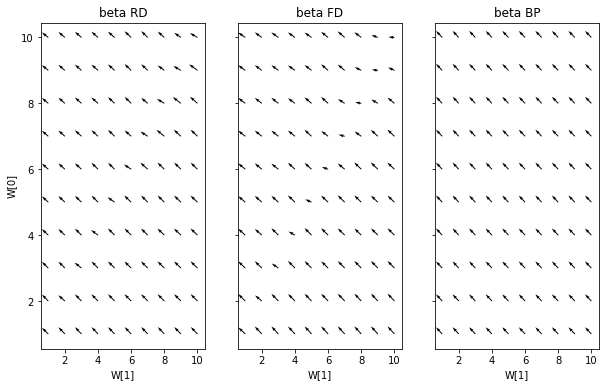

In [29]:
X, Y = np.meshgrid(np.linspace(1,10,N), np.linspace(1,10,N))

m_beta_rd_w = np.mean(beta_rd_w, 2)
m_beta_fd_w = np.mean(beta_fd_w, 2)
m_beta_bp_w = np.mean(beta_bp_w, 2)

figs, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True)
Q = ax1.quiver(X, Y, m_beta_rd_w[:,:,0], m_beta_rd_w[:,:,1])
Q = ax2.quiver(X, Y, m_beta_fd_w[:,:,0], m_beta_fd_w[:,:,1])
Q = ax3.quiver(X, Y, m_beta_bp_w[:,:,0], m_beta_bp_w[:,:,1])
ax1.set_title('beta RD')
ax1.set_ylabel('W[0]')
ax1.set_xlabel('W[1]')
ax2.set_title('beta FD')
ax2.set_xlabel('W[1]')
ax3.set_title('beta BP')
ax3.set_xlabel('W[1]');

We see the RD and FD disagree in cases where $W_0 \approx W_1$. which is the correlated inputs case. For heterogenous weights the correlated inputs induce less correlation in the output and FD performs the same as RD.

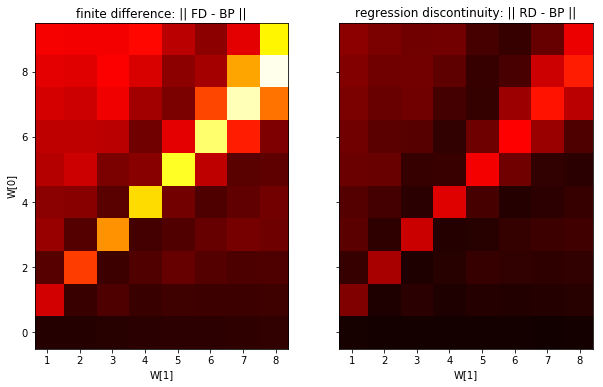

In [101]:
d_fdbp = np.sqrt((m_beta_fd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_fd_w[:,:,1]-m_beta_bp_w[:,:,1])**2)
d_rdbp = np.sqrt((m_beta_rd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_rd_w[:,:,1]-m_beta_bp_w[:,:,1])**2)

#Plot heat map of error in estimate
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)
ax1.imshow(d_fdbp, cmap='hot', origin='lower', vmin=0, vmax=80)
ax2.imshow(d_rdbp, cmap='hot', origin='lower', vmin=0, vmax=80);

ax1.set_title('finite difference: || FD - BP ||')
ax2.set_title('regression discontinuity: || RD - BP ||')
ax1.set_ylabel('W[0]')
ax1.set_xlabel('W[1]')
ax2.set_xlabel('W[1]');

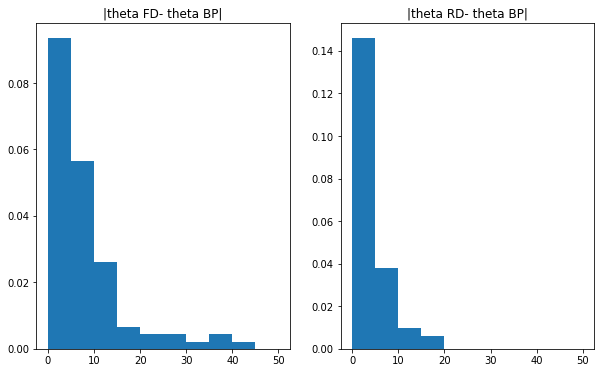

In [81]:
#Lump all these estimates together, and make histograms comparing overall performance of RD and FD to BP
fig, (ax1,ax2) = plt.subplots(1,2)

#Compute angle between $\beta_RD/FD$ and $\beta_BP$
m_beta_rd_w = np.mean(beta_rd_w, 2)
m_beta_fd_w = np.mean(beta_fd_w, 2)
m_beta_bp_w = np.mean(beta_bp_w, 2)

theta_rd = -180*np.arctan2(m_beta_rd_w[:,:,0].reshape((-1,1)), m_beta_rd_w[:,:,1].reshape((-1,1)))/np.pi
theta_fd = -180*np.arctan2(m_beta_fd_w[:,:,0].reshape((-1,1)), m_beta_fd_w[:,:,1].reshape((-1,1)))/np.pi
theta_bp = -180*np.arctan2(m_beta_bp_w[:,:,0].reshape((-1,1)), m_beta_bp_w[:,:,1].reshape((-1,1)))/np.pi

ax1.hist(theta_fd-theta_bp,10, normed=1, range=(0, 50));
ax2.hist(theta_rd-theta_bp,10, normed=1, range=(0, 50));
ax1.set_title('|theta FD- theta BP|')
ax2.set_title('|theta RD- theta BP|');

These are the histograms of absolute error in gradient angle $\theta$ between $\beta^{RD}$ and $\beta^{BP}$ (left) and $\beta^{FD}$ and $\beta^{BP}$ (right). For the 100 (10x10) pairs of weights chosen. The FD method has larger errors.

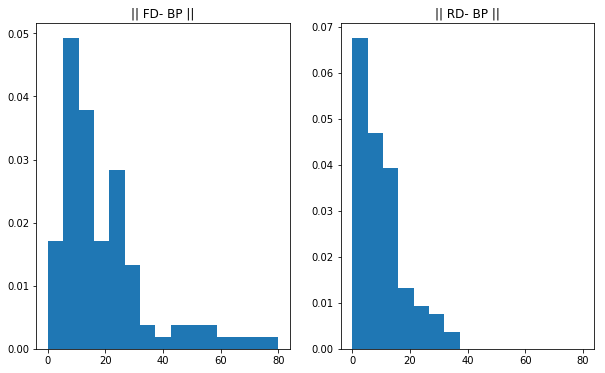

In [91]:
d_fdbp = np.sqrt((m_beta_fd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_fd_w[:,:,1]-m_beta_bp_w[:,:,1])**2).reshape((-1,1))
d_rdbp = np.sqrt((m_beta_rd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_rd_w[:,:,1]-m_beta_bp_w[:,:,1])**2).reshape((-1,1))

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.hist(d_fdbp,15, normed=1, range=(0, 80));
ax2.hist(d_rdbp,15, normed=1, range=(0, 80));
ax1.set_title('|| FD- BP ||')
ax2.set_title('|| RD- BP ||');

These are the histograms of $L2$ error in $\beta^{RD}$ (left) and $\beta^{FD}$ (right). For the 100 (10x10) pairs of weights chosen. The FD method has larger errors.

## 3.4 Comparing methods of estimating $\beta_i^{RD}$. Constant vs linear.

The above computes $\beta_i^{RD}$ just by estimating the mean in a window $p$ of the threshold. Probably we can get better performance by estimating a linear model within the window $p$.

In [4]:
params = ParamsLIF()
params_orig = ParamsLIF()
lif = LIF(params)

nsims = 500
cvals = 1-np.logspace(-2,0,7)
pvals = np.linspace(0.01, 1, 10)
#wvals = 

#c (correlation between noise inputs)
beta_rd_c = np.zeros((len(cvals), nsims, params.n))
beta_rd_linear_c = np.zeros((len(cvals), nsims, params.n))
beta_fd_c = np.zeros((len(cvals), nsims, params.n))
beta_bp_c = np.zeros((len(cvals), nsims, params.n))

#For each sim we come up with mean causal effect estimate for p = 0.05 (RD), and p = 1 (FD)
#Compute a 'bias-variance' tradeoff curve as a function of c, p, W

p = 0.1
for i,c in enumerate(cvals):
    print("Running %d simulations with c=%s"%(nsims, c))
    params.c = c
    lif.setup(params)
    for j in range(nsims):
        (v, h, Cost, betas) = lif.simulate()
        beta_rd_c[i,j,:] = causaleffect(v, Cost, p, params)
        beta_fd_c[i,j,:] = causaleffect(v, Cost, 1, params)
        beta_rd_linear_c[i,j,:] = causaleffect_linear(v, Cost, p, params)
        beta_bp_c[i,j,:] = betas
        
m_beta_rd_c = np.mean(beta_rd_c, 1)
se_beta_rd_c = np.std(beta_rd_c, 1)

m_beta_rd_linear_c = np.mean(beta_rd_linear_c, 1)
se_beta_rd_linear_c = np.std(beta_rd_linear_c, 1)

m_beta_fd_c = np.mean(beta_fd_c, 1)
se_beta_fd_c = np.std(beta_fd_c, 1)

m_beta_bp_c = np.mean(beta_bp_c, 1)
se_beta_bp_c = np.std(beta_bp_c, 1)

Running 500 simulations with c=0.99
Running 500 simulations with c=0.9784556531
Running 500 simulations with c=0.953584111664
Running 500 simulations with c=0.9
Running 500 simulations with c=0.784556530997
Running 500 simulations with c=0.535841116639
Running 500 simulations with c=0.0


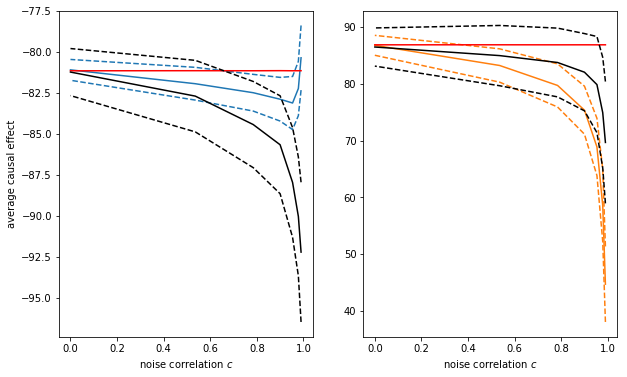

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2)

#RD
ax1.plot(cvals, m_beta_rd_c[:,0],'C0')
ax1.plot(cvals, m_beta_rd_c[:,0]+se_beta_rd_c[:,0],'--C0')
ax1.plot(cvals, m_beta_rd_c[:,0]-se_beta_rd_c[:,0],'--C0')

#RD_linear and BP
ax1.plot(cvals, m_beta_bp_c[:,0], color=(1,0,0))

ax1.plot(cvals, m_beta_rd_linear_c[:,0]+se_beta_rd_linear_c[:,0], '--', color=(0,0,0))
ax1.plot(cvals, m_beta_rd_linear_c[:,0]-se_beta_rd_linear_c[:,0], '--', color=(0,0,0))
ax1.plot(cvals, m_beta_rd_linear_c[:,0], color=(0,0,0))

#RD
ax2.plot(cvals, m_beta_rd_c[:,1],'C1')
ax2.plot(cvals, m_beta_rd_c[:,1]+se_beta_rd_c[:,1],'--C1')
ax2.plot(cvals, m_beta_rd_c[:,1]-se_beta_rd_c[:,1],'--C1')

#RD_linear and BP
ax2.plot(cvals, m_beta_bp_c[:,1], color=(1,0,0))

ax2.plot(cvals, m_beta_rd_linear_c[:,1]+se_beta_rd_linear_c[:,1], '--', color=(0,0,0))
ax2.plot(cvals, m_beta_rd_linear_c[:,1]-se_beta_rd_linear_c[:,1], '--', color=(0,0,0))
ax2.plot(cvals, m_beta_rd_linear_c[:,1], color=(0,0,0))

ax1.set_xlabel('noise correlation $c$')
ax1.set_ylabel('average causal effect')
ax2.set_xlabel('noise correlation $c$');

This shows there is no clear benefit to using a linear model (black curves), versus just estimating the mean (colored curves). However a more systematic study may provide more information...

## 3.5 Adding synaptic current outputs $s_i$

Above the output function was based on the spike times $h_i$. We can instead base the output on a synaptic current from the spiking of units $h_1$ and $h_2$. That is, let $s_i$ have dynamics:

$$
\tau_s \dot{s_i} = -s_i + \sum_{s=1}^{S_i}\delta(t-t_{i,s}),
$$
for spike times of unit $i$: $\{t_{i,s}\}_{s=1}^{S_i}$. The network's output is then given by:
$$
\mathbf{o} = O\mathbf{s},
$$
for an output matrix $O$. By filtering the spike trains a smoother output is produced.

## 3.6 Gradients with respect to weight

The above focuses on estimation of $\beta$ alone. We of course are concerned with using $\beta$ to perform weight updates, so need to know how it is integrated into a weight update step in a spiking network. What does the $C(W_0,W_1)$ surface/gradients look like, and how do the stochastic estimates compare?

We begin in the continuous case.

### Deterministic, continuous case 1

If our cost function is 

$$
C(h_1,h_2) = (v_1h_1 + v_2h_2 - x^2)^2
$$

for an input $x$. We have, for our LIF neurons, the relationship between input and firing rate:
$$
r_i(x) = \begin{cases}
\left[\tau_r - \tau\log\left(1-\frac{\mu}{W_i\sigma x}\right)\right]^{-1}&W_i \sigma x > \mu\\
0&\text{otherwise}
\end{cases}
$$

We replace the spiking units $h$ with their rates, which lets us compute $\frac{\partial C}{\partial W_j}$ simply
$$
\begin{align}
\frac{\partial C}{\partial W_j} &= \sigma x \frac{\partial C}{\partial r_j}r_j'(x)\\
&= \frac{\partial C}{\partial r_j}\frac{\mu \tau}{W_j (W_j \sigma x - \mu)\left(\tau_r - \tau \log\left(1-\frac{\mu}{W_j \sigma x}\right)\right)^2}\\
&= \left[2 v_j (v_1r_1+v_2r_2 - x^2)\right]\frac{\mu \tau r_j^2}{W_j (W_j \sigma x - \mu)}.
\end{align}
$$
We can see from the form that it will have a line of fixed points along $v_1h_1 + v_2h_2 - x^2=0$. This is not unique, so we should pick a different cost function.

### Deterministic, continuous case 2

Let
$$
C(h_1,h_2) = (v_1h_1 - x^2)^2 + (v_2h_2 - x^2)^2
$$

This separates optimization of $h_1$ and $h_2$, so is not that interesting. Nonetheless, the form of the gradients is
$$
\begin{align}
\frac{\partial C}{\partial W_j} &= \sigma x \frac{\partial C}{\partial r_j}r_j'(x)\\
&= \frac{\partial C}{\partial r_j}\frac{\mu \tau}{W_j (W_j \sigma x - \mu)\left(\tau_r - \tau \log\left(1-\frac{\mu}{W_j \sigma x}\right)\right)^2}\\
&= \left[2 v_j (v_jr_j - x^2)\right]\frac{\mu \tau r_j^2}{W_j (W_j \sigma x - \mu)}.
\end{align}
$$

### Deterministic, continuous case 3

We also optimize a more interesting, non-convex cost function:
$$
C(h_1,h_2) = (v_1h_1 - x)^2 + (v_2h_2 - v_1^2h_1^2)^2
$$
known as the Rosenbrock function.

The form of the gradients is
$$
\frac{\partial C}{\partial W_1} = \left[2 v_1 (v_1r_1 - x)-4r_1v_1^2(v_2r_2 - v_1^2r_1^2)\right]\frac{\mu \tau r_1^2}{W_1 (W_1 \sigma x - \mu)}
$$
and
$$
\frac{\partial C}{\partial W_2} = \left[2v_2(v_2r_2 - v_1^2r_1^2)\right]\frac{\mu \tau r_2^2}{W_2 (W_2 \sigma x - \mu)}.
$$

These look like the following.

In [4]:
def tabulate(x, y, f):
    """Return a table of f(x, y)."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

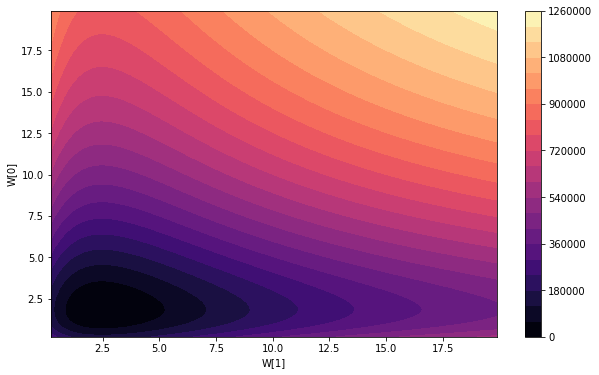

In [46]:
#Create a contour plot of $C$ as a function of $W_1,2$, show estimates for each method, using either BP, RD, FD
#Plot heat map of error in estimate
fig, ax1 = plt.subplots(1,1)
N = 100
wmin = 0.1
wmax = 20
sigma = 3; x = 20; v1 = 4; v2 = 5; tau_r = 0.003; tau = 1; mu = 1;

cost2 = lambda w1, w2: (v1*(1/(tau_r-tau*np.log(1-mu/(w1*sigma*x))))-x**2)**2+(v2*(1/(tau_r-tau*np.log(1-mu/(w2
            *sigma*x))))-x**2)**2
Cost2 = tabulate(np.linspace(wmin,wmax,N),np.linspace(wmin,wmax,N),cost2)

a=ax1.contourf(Cost2, 20, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_ylabel('W[0]')
ax1.set_xlabel('W[1]');
fig.colorbar(a);

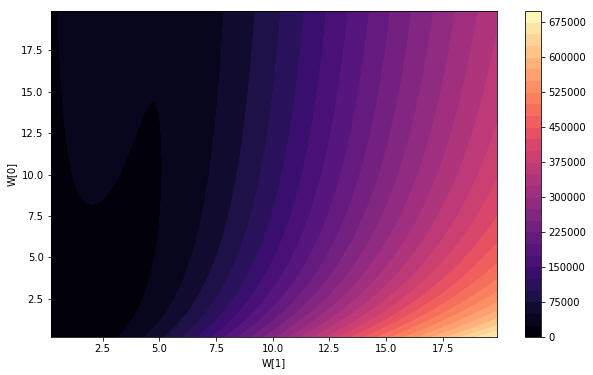

In [8]:
cost3 = lambda w1, w2: ((1/(tau_r-tau*np.log(1-mu/(w1*sigma*x))))-.1*x**2)**2+((1/(tau_r-tau*np.log(1-mu/(w2
            *sigma*x))))-.02*(1/(tau_r-tau*np.log(1-mu/(w1*sigma*x)))-70)**2-60)**2

wmin = 0.1
wmax = 20
Cost3 = tabulate(np.linspace(wmin,wmax,N),np.linspace(wmin,wmax,N),cost3)

fig, ax1 = plt.subplots(1,1)
a=ax1.contourf(Cost3, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_ylabel('W[0]')
ax1.set_xlabel('W[1]');
fig.colorbar(a);

### Stochastic, spiking case 2

It is difficult analytically to determine the mean cost surface as a function of weights. We rely on simulation to estimate the surface instead.

We run 500 simulations for each point in a 20x20 grid of weights for cost function 2. The surface looks like the following.

In [55]:
#Load simulations and compute different average cost functions
N = 20
nsims = 500
c = 0.1
wmax= 20

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)

hs = sims['hs']
vs = sims['vs']

#Compute cost
v1 = 4
v2 = 5
x = 20

tau_s = 0.03
dt = 0.001

In [56]:
N = 20
costs2 = np.zeros((N,N))
costs3 = np.zeros((N,N))

costs2_filtered = np.zeros((N,N))
costs3_filtered = np.zeros((N,N))

v1 = 5
v2 = -4

p = 0.03

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims, n))

m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))

params = ParamsLIF()

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*100*h1 + v2*100*h2 - x**2)**2
        #c3 = (h1 - 0.1*x**2)**2 + (h2-.02*(h1-70)**2-60)**2
        costs2[i,j] = np.mean(c2)
        #costs3[i,j] = np.mean(c3)
        for k in range(nsims):
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], p, params)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)
        
#c2 = (v1*1000*h1 + v2*1000*h2 - x**2)**2
#c3 = (h1*1000 - 0.1*x**2)**2 + (h2*1000-.02*(h1*1000-70)**2-60)**2
        
#Can also estimate the causal effects from here...
        
#m_beta_rd_w = np.mean(beta_rd_w, 2)
#m_beta_fd_w = np.mean(beta_fd_w, 2)
#m_beta_bp_w = np.mean(beta_bp_w, 2)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


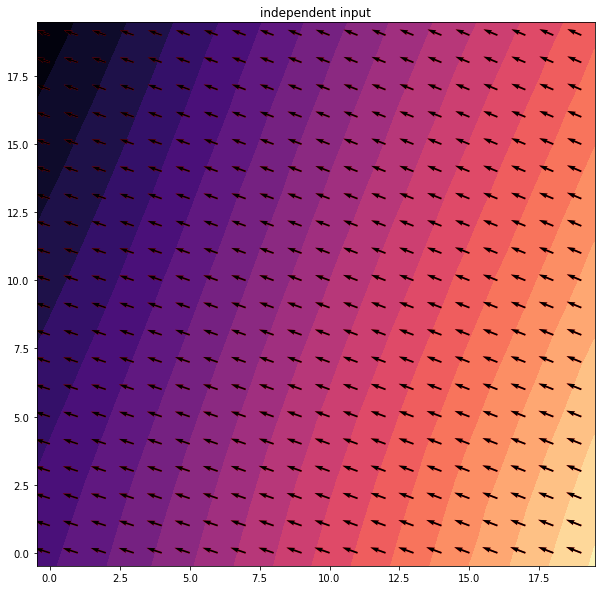

In [63]:
#Plot the cost gradients and cost contour map together
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = 20
wmin = -1
a=ax1.contourf(costs2, 20, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('independent input')

#fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(0,wmax-1,N), np.linspace(0,wmax-1,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1], -m_beta_fd_w[:,:,0], color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1], -m_beta_rd_w[:,:,0])

#fig, (ax2) = plt.subplots(1,1)
#Q = ax2.quiver(X, Y, m_beta_rd_w[:,:,0], m_beta_rd_w[:,:,1])
#ax2.set_title('independent input')
#ax2.contourf(costs2_ind, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
#fig.colorbar(a);


In [75]:
#Load simulations and compute different average cost functions
N = 20
c = 0.99
fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']

N = 20

costs2 = np.zeros((N,N))
costs3 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))
costs3_filtered = np.zeros((N,N))
beta_rd_w = np.zeros((nsims,n))
beta_fd_w = np.zeros((nsims,n))
m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))

v1 = 5
v2 = -4
x=10

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*100*h1 + v2*100*h2 - x**2)**2
        #c3 = (h1 - 0.1*x**2)**2 + (h2-.02*(h1-70)**2-60)**2
        costs2[i,j] = np.mean(c2)
        #costs3[i,j] = np.mean(c3)
        for k in range(nsims):
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], p, params)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


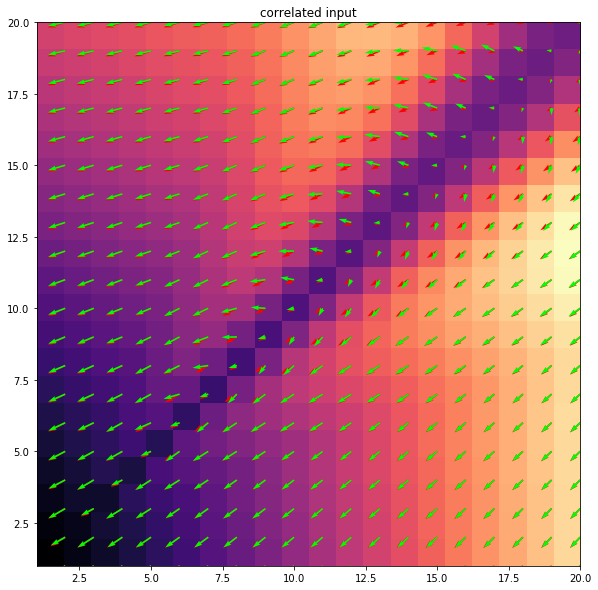

In [76]:
#Plot the cost gradients and cost contour map together
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = 20
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input')

#fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1].T, -m_beta_fd_w[:,:,0].T, color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1].T, -m_beta_rd_w[:,:,0].T, color=(0, 1, 0))


In [85]:
j = 1; meanh = np.mean(hs[:,j,:,1,:],(1,2))
np.mean(meanh)

0.0059964099999999998

In [96]:
#Load simulations and compute different average cost functions
#N = 20
#c = 0.99
#fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
#sims = np.load(fn_in)
#hs = sims['hs']
#vs = sims['vs']

N = 20

costs2 = np.zeros((N,N))
costs3 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))
costs3_filtered = np.zeros((N,N))
beta_rd_w = np.zeros((nsims,n))
beta_fd_w = np.zeros((nsims,n))
m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))

v1 = 5
v2 = -4
x=10

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*100*h1 - v1*5*10)**2 + (v2*100*h2 - v2*5*10)**2
        #c3 = (h1 - 0.1*x**2)**2 + (h2-.02*(h1-70)**2-60)**2
        costs2[i,j] = np.mean(c2)
        #costs3[i,j] = np.mean(c3)
        for k in range(nsims):
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2[k,:], p, params)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


/opt/anaconda/miniconda2/lib/python2.7/site-packages/matplotlib/quiver.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/anaconda/miniconda2/lib/python2.7/site-packages/matplotlib/quiver.py:664: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/anaconda/miniconda2/lib/python2.7/site-packages/matplotlib/quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/opt/anaconda/miniconda2/lib/python2.7/site-packages/matplotlib/quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


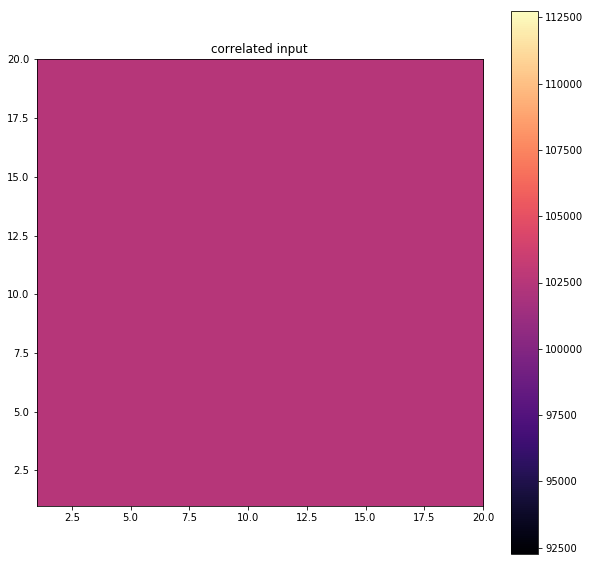

In [97]:
#Plot the cost gradients and cost contour map together
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = 20
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input')

#fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1].T, -m_beta_fd_w[:,:,0].T, color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1].T, -m_beta_rd_w[:,:,0].T, color=(0, 1, 0))
fig.colorbar(a)

The above suggests the RD estimator better gets at the deterministic cost function. However, the stochastic cost function is what we want to optimize? Therefore we do want to estimate FD??? Have to think about this.

## 3.7 Can a network learn $\beta_i^{RD}$?

The above show comparisons between FD, RD and BP for the case where we can estimate $\beta_i^{RD}$ offline, using whatever regression methods we like. We would like to implement this estimation in an online fashion, using a simple model a neuron/network may be able to mimic.

From Section 2.3 we simulate a second network whose output will be used to approximate $\beta_i^{RD}$.

In [310]:
from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM
from lib.causal import causaleffect, causaleffect_linear

In [311]:
q = 100
t = 5
params = ParamsLSM(q = q, p = 1, t = t)
lsm = LSM(params)

In [313]:
#Create two LIF neurons and train them to learn beta_i^{RD}
n = 2
params_lif = ParamsLIF()
lif = LIF(params_lif, t=t)

#Choose some random weights to represent beta_i
V = rand.randn(n, q)

tau_s = 0.020
t_filter = np.linspace(0, 0.06, 60)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

## Keeping a constant input $x$

In [290]:
(v, h, _, _) = lif.simulate()

In [291]:
s1.shape

(3000,)

In [316]:
#Learn beta_i through 20 simulations of LIF and LSM
N = 100
x = 5
eta = .005
p = .05
alpha1 = 8
alpha2 = 4
ds = exp_filter[0]
beta_rd = np.zeros((n, N))
V = 5*rand.randn(n, q)

for idx in range(N):
    #Simulate LSM
    s_lsm = lsm.simulate(x)
    #Simulate LIF
    (v, h, _, _) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
    s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]

    dVabv = np.zeros(V.shape)
    dVblo = np.zeros(V.shape)
    
    abvthr = np.zeros(n)
    blothr = np.zeros(n)
    
    dV = np.zeros(V.shape)
    for t in range(v.shape[1]):
        cost = (alpha1*s1[t] + alpha2*s2[t] - x**2)**2
        for k in range(n):
            if (v[k,t] > mu - p) & (v[k,t] < mu):
                blothr[k] += 1
                dV[k,:] = (np.dot(V[k,:], s_lsm[:,t])+cost)*s_lsm[:,t]
                bt = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                abvthr[k] += 1
                dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])-cost)*s_lsm[:,t]
                #Only do the update when firing...
                if bt:
                    V = V - eta*dV
                dV = np.zeros(V.shape)
                bt = False
    s_lsm = lsm.simulate(x)
    beta_rd[:,idx] = np.mean(np.dot(V, s_lsm[:,-100:]),1)

#Test how well we learnt beta through an extra second of simulation
print("N = %d. Unit 1. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[0], blothr[0], 100*float(abvthr[0])/(blothr[0]+abvthr[0])))
print("N = %d. Unit 2. Above thr %d: Below thr: %d. Percent above: %2.2f"%(idx, abvthr[1], blothr[1], 100*float(abvthr[1])/(blothr[1]+abvthr[1])))


N = 99. Unit 1. Above thr 50: Below thr: 90. Percent above: 35.71
N = 99. Unit 2. Above thr 44: Below thr: 66. Percent above: 40.00


(2, 100)

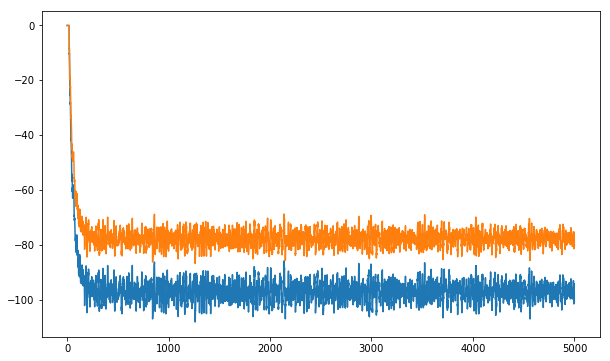

In [317]:
plt.plot(np.dot(V[0,:], s_lsm))
plt.plot(np.dot(V[1,:], s_lsm))
V.shape
#plt.plot(cost)

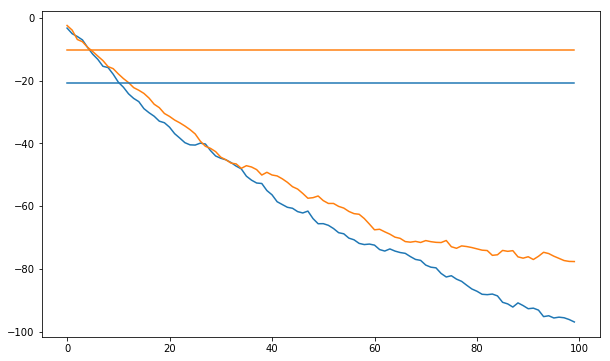

In [322]:
beta_bp1 = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2)*ds-2*alpha1*(x**2)*ds
beta_bp2 = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1)*ds-2*alpha2*(x**2)*ds
        
#Plot the learning progress
plt.plot(range(N), beta_rd[0,:], range(N), beta_rd[1,:]);
plt.plot(range(N), beta_bp1*np.ones(N), 'C0', range(N), beta_bp2*np.ones(N), 'C1');

In [227]:
ds

0.052038773303004472

## 4. Discussion